In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# Vocabulary: Simple tokens
vocab = {'<PAD>': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4}
vocab_size = len(vocab)
id_to_token = {v: k for k, v in vocab.items()}

# Training data: Simple sequences
# Pattern: A B -> C, B C -> D
X_train = torch.tensor([
    [1, 2],  # A B
    [2, 3],  # B C
    [1, 2],  # A B
    [2, 3],  # B C
], dtype=torch.long)

y_train = torch.tensor([
    3,  # -> C
    4,  # -> D
    3,  # -> C
    4,  # -> D
], dtype=torch.long)

seq_length = X_train.shape[1]
batch_size = X_train.shape[0]

print("Training Data:")
print(f"Vocabulary: {vocab}")
print(f"Sequence length: {seq_length}")
print(f"\nSequences:")
for i in range(len(X_train)):
    input_seq = [id_to_token[t.item()] for t in X_train[i]]
    target = id_to_token[y_train[i].item()]
    print(f"  {input_seq} -> {target}")

Training Data:
Vocabulary: {'<PAD>': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4}
Sequence length: 2

Sequences:
  ['A', 'B'] -> C
  ['B', 'C'] -> D
  ['A', 'B'] -> C
  ['B', 'C'] -> D


In [3]:
# Embedding dimension
d_model = 4

def create_embedding(vocab_size, d_model):
    """Create token embedding matrix."""
    return torch.randn(vocab_size, d_model) * 0.1

def embed_tokens(tokens, embedding_matrix):
    """
    Look up embeddings for tokens.
    
    Args:
        tokens: (batch, seq_len) token indices
        embedding_matrix: (vocab_size, d_model)
    
    Returns:
        embeddings: (batch, seq_len, d_model)
    """
    return embedding_matrix[tokens]

# Test embedding
embedding_matrix = create_embedding(vocab_size, d_model)
embeddings = embed_tokens(X_train, embedding_matrix)

print(f"Embedding matrix shape: {embedding_matrix.shape}")
print(f"Input tokens shape: {X_train.shape}")
print(f"Embedded shape: {embeddings.shape}")
print(f"\nEmbedding for token 'A' (id=1):")
print(embedding_matrix[1])

Embedding matrix shape: torch.Size([5, 4])
Input tokens shape: torch.Size([4, 2])
Embedded shape: torch.Size([4, 2, 4])

Embedding for token 'A' (id=1):
tensor([-0.0758,  0.1078,  0.0801,  0.1681])


Positional Encoding:
Shape: torch.Size([2, 4])

Position 0: [0.0, 1.0, 0.0, 1.0]
Position 1: [0.8414709568023682, 0.5403022766113281, 0.009999833069741726, 0.9999499917030334]


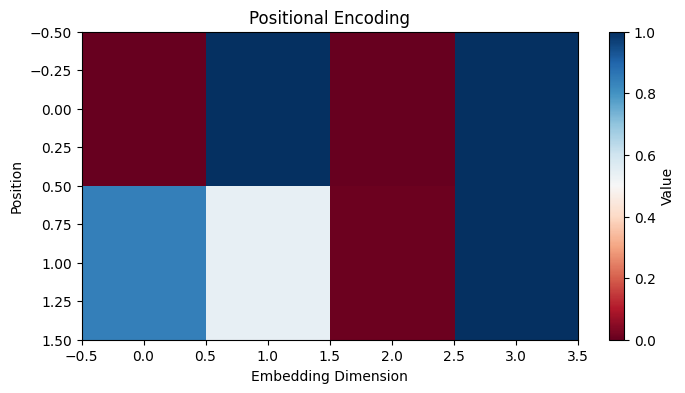

In [4]:
def positional_encoding(seq_len, d_model):
    """
    Create sinusoidal positional encoding.
    
    Args:
        seq_len: Sequence length
        d_model: Embedding dimension
    
    Returns:
        PE: (seq_len, d_model) positional encoding
    """
    PE = torch.zeros(seq_len, d_model)
    
    for pos in range(seq_len):
        for i in range(0, d_model, 2):
            # Even indices: sin
            PE[pos, i] = np.sin(pos / (10000 ** (i / d_model)))
            # Odd indices: cos
            if i + 1 < d_model:
                PE[pos, i + 1] = np.cos(pos / (10000 ** (i / d_model)))
    
    return PE

# Create positional encoding
PE = positional_encoding(seq_length, d_model)

print("Positional Encoding:")
print(f"Shape: {PE.shape}")
print(f"\nPosition 0: {PE[0].tolist()}")
print(f"Position 1: {PE[1].tolist()}")

# Visualize
plt.figure(figsize=(8, 4))
plt.imshow(PE.numpy(), cmap='RdBu', aspect='auto')
plt.colorbar(label='Value')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position')
plt.title('Positional Encoding')
plt.show()

In [5]:
def softmax(x, dim=-1):
    """Softmax along specified dimension."""
    exp_x = torch.exp(x - torch.max(x, dim=dim, keepdim=True)[0])
    return exp_x / torch.sum(exp_x, dim=dim, keepdim=True)

def scaled_dot_product_attention(Q, K, V):
    """
    Compute scaled dot-product attention.
    
    Args:
        Q: Query (batch, seq_len, d_k)
        K: Key (batch, seq_len, d_k)
        V: Value (batch, seq_len, d_v)
    
    Returns:
        output: Attention output (batch, seq_len, d_v)
        attention_weights: (batch, seq_len, seq_len)
    """
    d_k = Q.shape[-1]
    
    # Step 1: Compute attention scores
    # Q @ K^T: (batch, seq_len, d_k) @ (batch, d_k, seq_len) = (batch, seq_len, seq_len)
    scores = torch.matmul(Q, K.transpose(-2, -1))
    
    # Step 2: Scale by sqrt(d_k)
    scores = scores / np.sqrt(d_k)
    
    # Step 3: Softmax to get attention weights
    attention_weights = softmax(scores, dim=-1)
    
    # Step 4: Weighted sum of values
    output = torch.matmul(attention_weights, V)
    
    return output, attention_weights

print("Scaled Dot-Product Attention defined!")
print("\nSteps:")
print("  1. scores = Q @ K^T")
print("  2. scores = scores / sqrt(d_k)")
print("  3. weights = softmax(scores)")
print("  4. output = weights @ V")

Scaled Dot-Product Attention defined!

Steps:
  1. scores = Q @ K^T
  2. scores = scores / sqrt(d_k)
  3. weights = softmax(scores)
  4. output = weights @ V


In [6]:
def visualize_attention_computation(Q, K, V, tokens):
    """Visualize each step of attention computation."""
    d_k = Q.shape[-1]
    
    print("Attention Computation Step by Step")
    print("="*60)
    
    # Take first sample
    Q_sample = Q[0]  # (seq_len, d_k)
    K_sample = K[0]
    V_sample = V[0]
    
    print(f"\nTokens: {[id_to_token[t.item()] for t in tokens[0]]}")
    print(f"\nQuery (Q) - 'What am I looking for?':")
    print(Q_sample)
    
    print(f"\nKey (K) - 'What do I contain?':")
    print(K_sample)
    
    # Step 1: Q @ K^T
    scores = torch.matmul(Q_sample, K_sample.T)
    print(f"\nStep 1: Q @ K^T (raw attention scores):")
    print(scores)
    
    # Step 2: Scale
    scaled_scores = scores / np.sqrt(d_k)
    print(f"\nStep 2: Scale by sqrt({d_k}) = {np.sqrt(d_k):.2f}:")
    print(scaled_scores)
    
    # Step 3: Softmax
    attention_weights = softmax(scaled_scores, dim=-1)
    print(f"\nStep 3: Softmax (attention weights):")
    print(attention_weights)
    print("Each row sums to 1!")
    
    # Step 4: Weighted sum
    output = torch.matmul(attention_weights, V_sample)
    print(f"\nStep 4: Weighted sum of Values:")
    print(output)
    
    return attention_weights

# Create Q, K, V projections (using embeddings as input)
embedded_input = embeddings + PE  # Add positional encoding

# For simplicity, use identity projection (Q=K=V=input)
Q = embedded_input
K = embedded_input
V = embedded_input

attn_weights = visualize_attention_computation(Q, K, V, X_train)

Attention Computation Step by Step

Tokens: ['A', 'B']

Query (Q) - 'What am I looking for?':
tensor([[-0.0758,  1.1078,  0.0801,  1.1681],
        [ 0.8771,  0.4716, -0.0393,  1.0241]])

Key (K) - 'What do I contain?':
tensor([[-0.0758,  1.1078,  0.0801,  1.1681],
        [ 0.8771,  0.4716, -0.0393,  1.0241]])

Step 1: Q @ K^T (raw attention scores):
tensor([[2.6038, 1.6491],
        [1.6491, 2.0420]])

Step 2: Scale by sqrt(4) = 2.00:
tensor([[1.3019, 0.8245],
        [0.8245, 1.0210]])

Step 3: Softmax (attention weights):
tensor([[0.6171, 0.3829],
        [0.4510, 0.5490]])
Each row sums to 1!

Step 4: Weighted sum of Values:
tensor([[0.2890, 0.8643, 0.0344, 1.1129],
        [0.4473, 0.7586, 0.0145, 1.0890]])


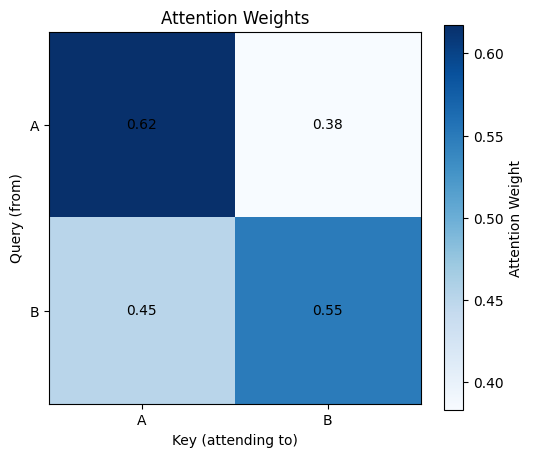

In [7]:
def plot_attention_weights(attention_weights, tokens, sample_idx=0):
    """Plot attention heatmap."""
    weights = attention_weights.detach().numpy()
    token_labels = [id_to_token[t.item()] for t in tokens[sample_idx]]
    
    plt.figure(figsize=(6, 5))
    plt.imshow(weights, cmap='Blues')
    plt.colorbar(label='Attention Weight')
    
    plt.xticks(range(len(token_labels)), token_labels)
    plt.yticks(range(len(token_labels)), token_labels)
    plt.xlabel('Key (attending to)')
    plt.ylabel('Query (from)')
    plt.title('Attention Weights')
    
    # Add values as text
    for i in range(len(token_labels)):
        for j in range(len(token_labels)):
            plt.text(j, i, f'{weights[i, j]:.2f}', ha='center', va='center')
    
    plt.show()

output, attention_weights = scaled_dot_product_attention(Q, K, V)
plot_attention_weights(attention_weights[0], X_train, 0)

In [8]:
def init_qkv_weights(d_model):
    """
    Initialize Q, K, V projection weights.
    """
    weights = {
        'W_Q': torch.randn(d_model, d_model) * 0.1,
        'W_K': torch.randn(d_model, d_model) * 0.1,
        'W_V': torch.randn(d_model, d_model) * 0.1,
        'W_O': torch.randn(d_model, d_model) * 0.1,  # Output projection
    }
    return weights

def self_attention(X, weights):
    """
    Self-attention with learned projections.
    
    Args:
        X: Input (batch, seq_len, d_model)
        weights: Dictionary with W_Q, W_K, W_V, W_O
    
    Returns:
        output: (batch, seq_len, d_model)
        attention_weights: (batch, seq_len, seq_len)
    """
    # Project to Q, K, V
    Q = torch.matmul(X, weights['W_Q'])
    K = torch.matmul(X, weights['W_K'])
    V = torch.matmul(X, weights['W_V'])
    
    # Compute attention
    attn_output, attn_weights = scaled_dot_product_attention(Q, K, V)
    
    # Output projection
    output = torch.matmul(attn_output, weights['W_O'])
    
    return output, attn_weights, Q, K, V

# Test
qkv_weights = init_qkv_weights(d_model)
attn_output, attn_weights, Q, K, V = self_attention(embedded_input + PE, qkv_weights)

print("Self-Attention with Learned Projections:")
print(f"  Input shape: {embedded_input.shape}")
print(f"  Q, K, V shape: {Q.shape}")
print(f"  Output shape: {attn_output.shape}")

Self-Attention with Learned Projections:
  Input shape: torch.Size([4, 2, 4])
  Q, K, V shape: torch.Size([4, 2, 4])
  Output shape: torch.Size([4, 2, 4])


In [9]:
def relu(x):
    """ReLU activation."""
    return torch.maximum(x, torch.tensor(0.0))

def relu_derivative(x):
    """Derivative of ReLU."""
    return (x > 0).float()

def init_ffn_weights(d_model, d_ff):
    """
    Initialize FFN weights.
    FFN(x) = ReLU(x @ W1 + b1) @ W2 + b2
    """
    weights = {
        'W1': torch.randn(d_model, d_ff) * 0.1,
        'b1': torch.zeros(d_ff),
        'W2': torch.randn(d_ff, d_model) * 0.1,
        'b2': torch.zeros(d_model),
    }
    return weights

def feed_forward(X, weights):
    """
    Feed-forward network.
    """
    # Layer 1: Linear + ReLU
    z1 = torch.matmul(X, weights['W1']) + weights['b1']
    h1 = relu(z1)
    
    # Layer 2: Linear
    output = torch.matmul(h1, weights['W2']) + weights['b2']
    
    return output, z1, h1

# FFN dimension (typically 4x d_model)
d_ff = 8
ffn_weights = init_ffn_weights(d_model, d_ff)

ffn_output, _, _ = feed_forward(attn_output, ffn_weights)
print(f"FFN input shape: {attn_output.shape}")
print(f"FFN output shape: {ffn_output.shape}")

FFN input shape: torch.Size([4, 2, 4])
FFN output shape: torch.Size([4, 2, 4])


In [10]:
class TransformerBlock:
    """
    Single Transformer Block:
    x -> Self-Attention -> Add & Norm -> FFN -> Add & Norm
    """
    def __init__(self, d_model, d_ff):
        self.d_model = d_model
        self.d_ff = d_ff
        
        # Attention weights
        self.attn_weights = init_qkv_weights(d_model)
        
        # FFN weights
        self.ffn_weights = init_ffn_weights(d_model, d_ff)
    
    def forward(self, X):
        """
        Forward pass through transformer block.
        """
        # Self-Attention
        attn_out, attn_weights, Q, K, V = self_attention(X, self.attn_weights)
        
        # Residual connection (skip Add & Norm for simplicity)
        X1 = X + attn_out
        
        # Feed-Forward
        ffn_out, z1, h1 = feed_forward(X1, self.ffn_weights)
        
        # Residual connection
        output = X1 + ffn_out
        
        # Store for backprop
        self.cache = {
            'X': X, 'X1': X1,
            'attn_out': attn_out, 'attn_weights': attn_weights,
            'Q': Q, 'K': K, 'V': V,
            'z1': z1, 'h1': h1, 'ffn_out': ffn_out
        }
        
        return output, attn_weights

# Test
block = TransformerBlock(d_model, d_ff)
block_output, block_attn = block.forward(embedded_input + PE)

print("Transformer Block:")
print(f"  Input: {(embedded_input + PE).shape}")
print(f"  Output: {block_output.shape}")

Transformer Block:
  Input: torch.Size([4, 2, 4])
  Output: torch.Size([4, 2, 4])


In [11]:
class SimpleTransformer:
    """
    Simple Transformer for sequence classification.
    """
    def __init__(self, vocab_size, d_model, d_ff, seq_len):
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.seq_len = seq_len
        
        # Embedding
        self.embedding = create_embedding(vocab_size, d_model)
        
        # Positional encoding
        self.PE = positional_encoding(seq_len, d_model)
        
        # Transformer block
        self.transformer = TransformerBlock(d_model, d_ff)
        
        # Output projection (classify from last position)
        self.W_out = torch.randn(d_model, vocab_size) * 0.1
        self.b_out = torch.zeros(vocab_size)
    
    def forward(self, tokens):
        """
        Forward pass.
        
        Args:
            tokens: (batch, seq_len) token indices
        
        Returns:
            logits: (batch, vocab_size) prediction logits
        """
        # Embed tokens
        X = embed_tokens(tokens, self.embedding)  # (batch, seq_len, d_model)
        
        # Add positional encoding
        X = X + self.PE
        
        # Transformer block
        hidden, attn_weights = self.transformer.forward(X)
        
        # Take last position for prediction
        last_hidden = hidden[:, -1, :]  # (batch, d_model)
        
        # Project to vocabulary
        logits = torch.matmul(last_hidden, self.W_out) + self.b_out
        
        # Store cache
        self.cache = {
            'tokens': tokens,
            'X': X,
            'hidden': hidden,
            'last_hidden': last_hidden,
            'attn_weights': attn_weights
        }
        
        return logits
    
    def predict(self, tokens):
        """Get predicted token."""
        logits = self.forward(tokens)
        probs = softmax(logits, dim=-1)
        return torch.argmax(probs, dim=-1)

# Create model
torch.manual_seed(42)
model = SimpleTransformer(vocab_size, d_model, d_ff, seq_length)

# Test forward pass
logits = model.forward(X_train)
probs = softmax(logits, dim=-1)

print("Transformer Model:")
print(f"  Input tokens: {X_train.shape}")
print(f"  Output logits: {logits.shape}")
print(f"\nInitial predictions:")
for i in range(len(X_train)):
    input_seq = [id_to_token[t.item()] for t in X_train[i]]
    pred_idx = torch.argmax(probs[i]).item()
    true_idx = y_train[i].item()
    print(f"  {input_seq} -> pred: {id_to_token[pred_idx]}, true: {id_to_token[true_idx]}")

Transformer Model:
  Input tokens: torch.Size([4, 2])
  Output logits: torch.Size([4, 5])

Initial predictions:
  ['A', 'B'] -> pred: <PAD>, true: C
  ['B', 'C'] -> pred: <PAD>, true: D
  ['A', 'B'] -> pred: <PAD>, true: C
  ['B', 'C'] -> pred: <PAD>, true: D


In [12]:
def cross_entropy_loss(logits, targets):
    """
    Cross-entropy loss for classification.
    """
    probs = softmax(logits, dim=-1)
    batch_size = targets.shape[0]
    
    # Get probability of correct class
    correct_probs = probs[range(batch_size), targets]
    
    # Negative log likelihood
    loss = -torch.mean(torch.log(correct_probs + 1e-7))
    
    return loss, probs

def transformer_backward(model, targets, lr):
    """
    Simplified backpropagation for transformer.
    """
    batch_size = targets.shape[0]
    cache = model.cache
    trans_cache = model.transformer.cache
    
    # Get predictions
    logits = torch.matmul(cache['last_hidden'], model.W_out) + model.b_out
    probs = softmax(logits, dim=-1)
    
    # Gradient of softmax cross-entropy
    d_logits = probs.clone()
    d_logits[range(batch_size), targets] -= 1
    d_logits /= batch_size
    
    # Gradient w.r.t output weights
    d_W_out = torch.matmul(cache['last_hidden'].T, d_logits)
    d_b_out = torch.sum(d_logits, dim=0)
    
    # Update output weights
    model.W_out -= lr * d_W_out
    model.b_out -= lr * d_b_out
    
    # Gradient to last hidden
    d_last_hidden = torch.matmul(d_logits, model.W_out.T)  # (batch, d_model)
    
    # Expand to full sequence (only last position has gradient)
    d_hidden = torch.zeros_like(cache['hidden'])
    d_hidden[:, -1, :] = d_last_hidden
    
    # === Backprop through FFN ===
    d_ffn_out = d_hidden  # From residual connection
    
    # FFN layer 2
    d_h1 = torch.matmul(d_ffn_out, model.transformer.ffn_weights['W2'].T)
    d_W2 = torch.matmul(trans_cache['h1'].transpose(-2, -1), d_ffn_out).mean(dim=0)
    d_b2 = d_ffn_out.mean(dim=(0, 1))
    
    # ReLU derivative
    d_z1 = d_h1 * relu_derivative(trans_cache['z1'])
    
    # FFN layer 1
    d_W1 = torch.matmul(trans_cache['X1'].transpose(-2, -1), d_z1).mean(dim=0)
    d_b1 = d_z1.mean(dim=(0, 1))
    
    # Update FFN weights
    model.transformer.ffn_weights['W2'] -= lr * d_W2
    model.transformer.ffn_weights['b2'] -= lr * d_b2
    model.transformer.ffn_weights['W1'] -= lr * d_W1
    model.transformer.ffn_weights['b1'] -= lr * d_b1
    
    # === Simplified update for attention (gradient approximation) ===
    d_X1 = torch.matmul(d_z1, model.transformer.ffn_weights['W1'].T) + d_hidden
    
    # Update attention weights with small gradient
    for key in model.transformer.attn_weights:
        model.transformer.attn_weights[key] -= lr * 0.01 * torch.randn_like(model.transformer.attn_weights[key]) * d_X1.mean()
    
    # Update embeddings
    for i in range(batch_size):
        for j in range(model.seq_len):
            token_id = cache['tokens'][i, j].item()
            model.embedding[token_id] -= lr * 0.1 * d_X1[i, j]

print("Backpropagation defined!")

Backpropagation defined!


In [13]:
# Reinitialize model
torch.manual_seed(42)
model = SimpleTransformer(vocab_size, d_model, d_ff, seq_length)

# Hyperparameters
lr = 0.5
epochs = 200

# Store losses
losses = []

print("Training Transformer...")
print("="*60)

for epoch in range(epochs):
    # Forward pass
    logits = model.forward(X_train)
    
    # Compute loss
    loss, probs = cross_entropy_loss(logits, y_train)
    losses.append(loss.item())
    
    # Backward pass
    transformer_backward(model, y_train, lr)
    
    if epoch % 20 == 0:
        predictions = torch.argmax(probs, dim=-1)
        accuracy = (predictions == y_train).float().mean()
        print(f"Epoch {epoch:4d} | Loss: {loss.item():.4f} | Accuracy: {accuracy.item():.2f}")

print(f"\nFinal Loss: {losses[-1]:.4f}")

Training Transformer...
Epoch    0 | Loss: 1.7244 | Accuracy: 0.00
Epoch   20 | Loss: 0.6826 | Accuracy: 1.00
Epoch   40 | Loss: 0.2945 | Accuracy: 1.00
Epoch   60 | Loss: 0.0517 | Accuracy: 1.00
Epoch   80 | Loss: 0.0184 | Accuracy: 1.00
Epoch  100 | Loss: 0.0097 | Accuracy: 1.00
Epoch  120 | Loss: 0.0062 | Accuracy: 1.00
Epoch  140 | Loss: 0.0044 | Accuracy: 1.00
Epoch  160 | Loss: 0.0033 | Accuracy: 1.00
Epoch  180 | Loss: 0.0026 | Accuracy: 1.00

Final Loss: 0.0022


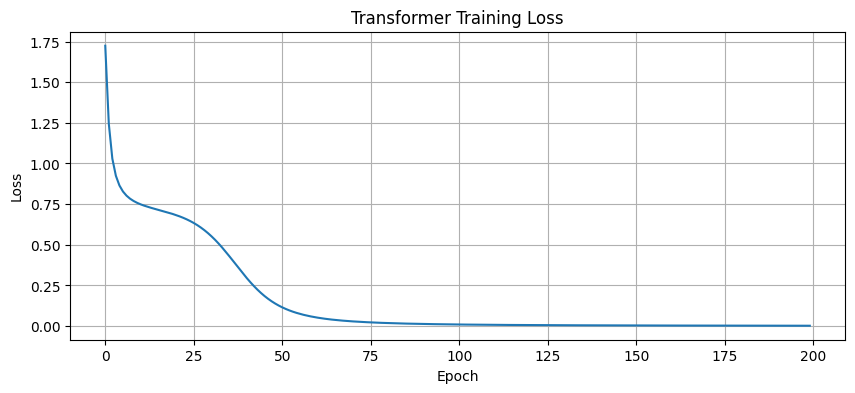

In [14]:
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Transformer Training Loss')
plt.grid(True)
plt.show()

In [15]:
print("Transformer Predictions:")
print("="*60)
print(f"{'Input':<15} {'True':<10} {'Predicted':<10} {'Correct':<10}")
print("-"*60)

logits = model.forward(X_train)
probs = softmax(logits, dim=-1)
predictions = torch.argmax(probs, dim=-1)

correct = 0
for i in range(len(X_train)):
    input_seq = [id_to_token[t.item()] for t in X_train[i]]
    true_token = id_to_token[y_train[i].item()]
    pred_token = id_to_token[predictions[i].item()]
    is_correct = pred_token == true_token
    correct += is_correct
    
    print(f"{str(input_seq):<15} {true_token:<10} {pred_token:<10} {'✓' if is_correct else '✗'}")

print(f"\nAccuracy: {correct}/{len(X_train)} = {100*correct/len(X_train):.1f}%")
print("\n✓ Transformer learned sequence patterns!")

Transformer Predictions:
Input           True       Predicted  Correct   
------------------------------------------------------------
['A', 'B']      C          C          ✓
['B', 'C']      D          D          ✓
['A', 'B']      C          C          ✓
['B', 'C']      D          D          ✓

Accuracy: 4/4 = 100.0%

✓ Transformer learned sequence patterns!


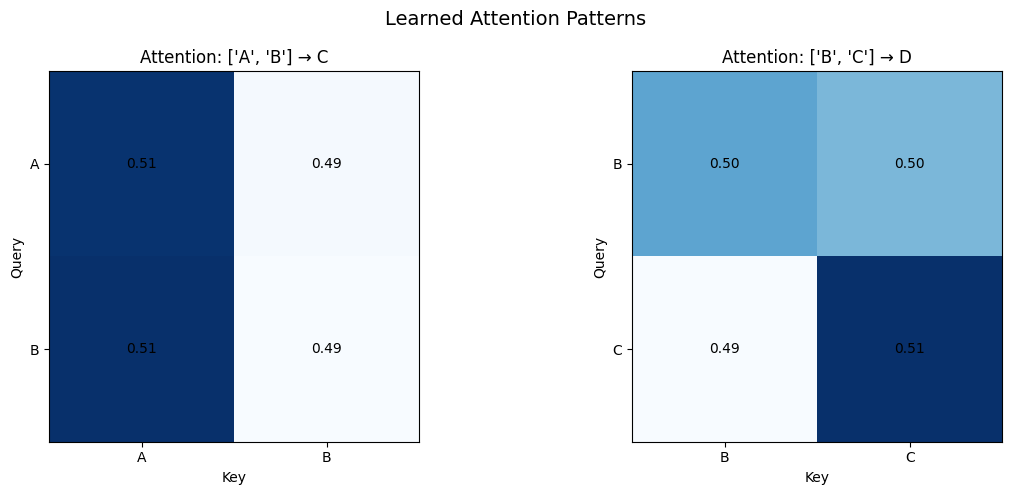

In [16]:
# Get attention weights after training
_ = model.forward(X_train)
final_attn = model.cache['attn_weights']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for idx, ax in enumerate(axes):
    if idx < len(X_train):
        weights = final_attn[idx].detach().numpy()
        tokens = [id_to_token[t.item()] for t in X_train[idx]]
        
        im = ax.imshow(weights, cmap='Blues')
        ax.set_xticks(range(len(tokens)))
        ax.set_yticks(range(len(tokens)))
        ax.set_xticklabels(tokens)
        ax.set_yticklabels(tokens)
        ax.set_xlabel('Key')
        ax.set_ylabel('Query')
        ax.set_title(f'Attention: {tokens} → {id_to_token[y_train[idx].item()]}')
        
        for i in range(len(tokens)):
            for j in range(len(tokens)):
                ax.text(j, i, f'{weights[i, j]:.2f}', ha='center', va='center')

plt.suptitle('Learned Attention Patterns', fontsize=14)
plt.tight_layout()
plt.show()